# Analysing Twitter Data to Predict the Price/Returns of the FTSE Index

## Abstract
The five-week final project for my General Assembly data science immersive programme. I built a model that predicted (FTSE) Index Stock Returns using Twitter Sentiment.
   The first step involved constructing the dataframe. I scraped Twitter and conducted Vader sentiment analysis on the dataset, I then downloaded the FTSE historical data, created the Returns column, and joined the two dataframes together to get the final dataset. 
        The second step involves the application of modelling techniques on the dataset, I applied Linear Regression modelling. The results highlighted that this was a poor model, the predicted score was lower than the baseline (0.0022320_LR). From a statistical point of view its a pretty bad model, but it is important to look from an economic perspective. 
        For the final step of the project, I conducted a backtest and devised a trading strategy that predicted the direction and return of the FTSE index. I established cumulative P&L scores, which showed that from an economic perspective that it is a good course of action.

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import datetime as dt
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import calendar
import scipy.stats as stats
import csv
import os

In [2]:
import GetOldTweets3 as got
from tweepy import Stream                   
from tweepy.streaming import StreamListener
import webbrowser
import time

In [3]:
from joblib import Parallel,delayed
from math import sqrt

In [4]:
df =pd.DataFrame(columns=['date','text', 'username', 'hashtags', 'favorites', 'retweets', 'mentions', 'replies'])

In [5]:
# March 2007 Housing Market Crash

# Constructing The Twitter Scraper
## Scaping Tweets that mention the 'FTSE' Index
- I wanted to get data that covered a full economic cycle, so i set the date range from February 2007, a few month   prior to the burst of the housing bubble in the US. 

- Twitter API is limitited to scraping 18,000 tweets per a 15 minute window. Because of this i set the maximum       number of tweets that can be scraped per day to 1200 so that the scraper isnt too time consuming.

- I extracted the 'date','text', 'username', 'hashtags', 'favorites', 'retweets', 'mentions', 'replies' from each   tweet scraped.

In [18]:
def my_pmap(f,jobs,num_procs=10):  
    return Parallel(n_jobs=num_procs)(delayed(f)(i) for i in jobs)

In [19]:
from datetime import datetime
from time import time,sleep
num_tweets = 1200
want_incremental = True
num_tweets_enc = 0
start_time = time()
dt_range = pd.date_range(start=datetime(2007, 2, 1),  end =datetime(2020, 8, 15))
index = 'FTSE'
def datewise(dt):
        if (os.path.exists(f'Equity_sentiment_twitter/tweets_{index}_{dt:%Y%m%d}.csv') and want_incremental):
            return
        print(f' i am inside date {dt:%Y%m%d}')
        successful_api_call= False
        while successful_api_call==False:
            try:
                tweetCriteria = got.manager.TweetCriteria().setQuerySearch(f'{index}')\
                                               .setSince(f'{dt:%Y-%m-%d}')\
                                               .setUntil(f'{dt+pd.Timedelta(days=1):%Y-%m-%d}')\
                                               .setMaxTweets(num_tweets)\
                                               .setEmoji("unicode")\
                                               .setLang('english')
                tweet = got.manager.TweetManager.getTweets(tweetCriteria)
                successful_api_call = True
            except:
                print(f'Encountered an error. Retrying.')
                
        print(f'Day tweets = {len(tweet)}')
        df = pd.DataFrame(columns=['date','text', 'username', 'hashtags', 'favorites', 'retweets', 'mentions', 'replies'])
        for i in range(0, len(tweet)):
            mydict = {'author_id':tweet[i].author_id, 'date':tweet[i].date,'text':tweet[i].text, 'username':tweet[i].username, 'hashtags':tweet[i].hashtags, 'retweets':tweet[i].retweets, 'favorites':tweet[i].favorites, 'mentions':tweet[i].mentions, 'replies':tweet[i].replies}
            df = df.append(mydict,ignore_index=~True)
        df.to_csv(f'Equity_sentiment_twitter/tweets_{index}_{dt:%Y%m%d}.csv')
        


my_pmap(datewise,dt_range,num_procs=-1)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# Assigning Sentiment Score to each Tweet with VADER

- The VADER library is limited when conducting analysis on Financial subject matters.  So I added certain words which I considered important, as well as this I incorporated the Loughran-McDonald finance word dictionary so as to make the sentiment scores more precise.

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
pos_words = ['up','bull','high']
neg_words = ['down','bear','low']
uncertain_words = ['shaky']
words = pd.read_csv('finance_dict.csv')
for col in words.columns:
    words[col] = words[col].str.lower()
pos_words = pos_words + list(words.positive)
neg_words = neg_words + list(words.negative)
uncertain_words = uncertain_words + list(words.uncertain)

new_words_dict = {}
for word in pos_words + neg_words + uncertain_words:
    if word in pos_words:
        new_words_dict[word] = 1
    elif word in neg_words:
        new_words_dict[word] = -1
    else:
        new_words_dict[word] = -0.2

analyzer.lexicon.update(new_words_dict)

In [21]:
words# Loughran-McDonald finance word dictionary

,negative,positive,uncertain
0,abandon,able,abeyance
1,abandoned,abundance,abeyances
2,abandoning,abundant,almost
3,abandonment,acclaimed,alteration
4,abandonments,accomplish,alterations
...,...,...,...
2350,wrongdoing,NaN,NaN
2351,wrongdoings,NaN,NaN
2352,wrongful,NaN,NaN
2353,wrongfully,NaN,NaN


## Example

In [22]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['compound']
    
sentiment_analyzer_scores('ftse might see a bull in stock price ')

0.2023

## Consolidating the seperate tweets and sentiment CSV files into one big CSV

In [25]:
df = []
# dt_range = pd.date_range(start=datetime(2011,1,1),end=datetime(2011,1,31))
for dt in dt_range:
    print(f' i am inside date {dt:%Y%m%d}')
    if not os.path.exists(f'Equity_sentiment_twitter/tweets_{index}_{dt:%Y%m%d}.csv'):
        continue
    df.append(pd.read_csv(f'Equity_sentiment_twitter/tweets_{index}_{dt:%Y%m%d}.csv'))
df = pd.concat(df,ignore_index=True)
df.text = df.text.astype(str)
if not os.path.exists(f'Equity_sentiment_twitter/{index}_consolidated'):
    os.mkdir(f'Equity_sentiment_twitter/{index}_consolidated')
df.to_csv(f'Equity_sentiment_twitter/{index}_consolidated/tweets_and_sentiment_consolidated.csv')
df['score'] = df.text.apply(lambda x: sentiment_analyzer_scores(x))
df.to_csv(f'Equity_sentiment_twitter/{index}_consolidated/tweets_and_sentiment_consolidated_with_sentiment.csv')



 i am inside date 20070201
 i am inside date 20070202
 i am inside date 20070203
 i am inside date 20070204
 i am inside date 20070205
 i am inside date 20070206
 i am inside date 20070207
 i am inside date 20070208
 i am inside date 20070209
 i am inside date 20070210
 i am inside date 20070211
 i am inside date 20070212
 i am inside date 20070213
 i am inside date 20070214
 i am inside date 20070215
 i am inside date 20070216
 i am inside date 20070217
 i am inside date 20070218
 i am inside date 20070219
 i am inside date 20070220
 i am inside date 20070221
 i am inside date 20070222
 i am inside date 20070223
 i am inside date 20070224
 i am inside date 20070225
 i am inside date 20070226
 i am inside date 20070227
 i am inside date 20070228
 i am inside date 20070301
 i am inside date 20070302
 i am inside date 20070303
 i am inside date 20070304
 i am inside date 20070305
 i am inside date 20070306
 i am inside date 20070307
 i am inside date 20070308
 i am inside date 20070309
 

 i am inside date 20071207
 i am inside date 20071208
 i am inside date 20071209
 i am inside date 20071210
 i am inside date 20071211
 i am inside date 20071212
 i am inside date 20071213
 i am inside date 20071214
 i am inside date 20071215
 i am inside date 20071216
 i am inside date 20071217
 i am inside date 20071218
 i am inside date 20071219
 i am inside date 20071220
 i am inside date 20071221
 i am inside date 20071222
 i am inside date 20071223
 i am inside date 20071224
 i am inside date 20071225
 i am inside date 20071226
 i am inside date 20071227
 i am inside date 20071228
 i am inside date 20071229
 i am inside date 20071230
 i am inside date 20071231
 i am inside date 20080101
 i am inside date 20080102
 i am inside date 20080103
 i am inside date 20080104
 i am inside date 20080105
 i am inside date 20080106
 i am inside date 20080107
 i am inside date 20080108
 i am inside date 20080109
 i am inside date 20080110
 i am inside date 20080111
 i am inside date 20080112
 

 i am inside date 20081008
 i am inside date 20081009
 i am inside date 20081010
 i am inside date 20081011
 i am inside date 20081012
 i am inside date 20081013
 i am inside date 20081014
 i am inside date 20081015
 i am inside date 20081016
 i am inside date 20081017
 i am inside date 20081018
 i am inside date 20081019
 i am inside date 20081020
 i am inside date 20081021
 i am inside date 20081022
 i am inside date 20081023
 i am inside date 20081024
 i am inside date 20081025
 i am inside date 20081026
 i am inside date 20081027
 i am inside date 20081028
 i am inside date 20081029
 i am inside date 20081030
 i am inside date 20081031
 i am inside date 20081101
 i am inside date 20081102
 i am inside date 20081103
 i am inside date 20081104
 i am inside date 20081105
 i am inside date 20081106
 i am inside date 20081107
 i am inside date 20081108
 i am inside date 20081109
 i am inside date 20081110
 i am inside date 20081111
 i am inside date 20081112
 i am inside date 20081113
 

 i am inside date 20090825
 i am inside date 20090826
 i am inside date 20090827
 i am inside date 20090828
 i am inside date 20090829
 i am inside date 20090830
 i am inside date 20090831
 i am inside date 20090901
 i am inside date 20090902
 i am inside date 20090903
 i am inside date 20090904
 i am inside date 20090905
 i am inside date 20090906
 i am inside date 20090907
 i am inside date 20090908
 i am inside date 20090909
 i am inside date 20090910
 i am inside date 20090911
 i am inside date 20090912
 i am inside date 20090913
 i am inside date 20090914
 i am inside date 20090915
 i am inside date 20090916
 i am inside date 20090917
 i am inside date 20090918
 i am inside date 20090919
 i am inside date 20090920
 i am inside date 20090921
 i am inside date 20090922
 i am inside date 20090923
 i am inside date 20090924
 i am inside date 20090925
 i am inside date 20090926
 i am inside date 20090927
 i am inside date 20090928
 i am inside date 20090929
 i am inside date 20090930
 

 i am inside date 20100715
 i am inside date 20100716
 i am inside date 20100717
 i am inside date 20100718
 i am inside date 20100719
 i am inside date 20100720
 i am inside date 20100721
 i am inside date 20100722
 i am inside date 20100723
 i am inside date 20100724
 i am inside date 20100725
 i am inside date 20100726
 i am inside date 20100727
 i am inside date 20100728
 i am inside date 20100729
 i am inside date 20100730
 i am inside date 20100731
 i am inside date 20100801
 i am inside date 20100802
 i am inside date 20100803
 i am inside date 20100804
 i am inside date 20100805
 i am inside date 20100806
 i am inside date 20100807
 i am inside date 20100808
 i am inside date 20100809
 i am inside date 20100810
 i am inside date 20100811
 i am inside date 20100812
 i am inside date 20100813
 i am inside date 20100814
 i am inside date 20100815
 i am inside date 20100816
 i am inside date 20100817
 i am inside date 20100818
 i am inside date 20100819
 i am inside date 20100820
 

 i am inside date 20110518
 i am inside date 20110519
 i am inside date 20110520
 i am inside date 20110521
 i am inside date 20110522
 i am inside date 20110523
 i am inside date 20110524
 i am inside date 20110525
 i am inside date 20110526
 i am inside date 20110527
 i am inside date 20110528
 i am inside date 20110529
 i am inside date 20110530
 i am inside date 20110531
 i am inside date 20110601
 i am inside date 20110602
 i am inside date 20110603
 i am inside date 20110604
 i am inside date 20110605
 i am inside date 20110606
 i am inside date 20110607
 i am inside date 20110608
 i am inside date 20110609
 i am inside date 20110610
 i am inside date 20110611
 i am inside date 20110612
 i am inside date 20110613
 i am inside date 20110614
 i am inside date 20110615
 i am inside date 20110616
 i am inside date 20110617
 i am inside date 20110618
 i am inside date 20110619
 i am inside date 20110620
 i am inside date 20110621
 i am inside date 20110622
 i am inside date 20110623
 

 i am inside date 20120321
 i am inside date 20120322
 i am inside date 20120323
 i am inside date 20120324
 i am inside date 20120325
 i am inside date 20120326
 i am inside date 20120327
 i am inside date 20120328
 i am inside date 20120329
 i am inside date 20120330
 i am inside date 20120331
 i am inside date 20120401
 i am inside date 20120402
 i am inside date 20120403
 i am inside date 20120404
 i am inside date 20120405
 i am inside date 20120406
 i am inside date 20120407
 i am inside date 20120408
 i am inside date 20120409
 i am inside date 20120410
 i am inside date 20120411
 i am inside date 20120412
 i am inside date 20120413
 i am inside date 20120414
 i am inside date 20120415
 i am inside date 20120416
 i am inside date 20120417
 i am inside date 20120418
 i am inside date 20120419
 i am inside date 20120420
 i am inside date 20120421
 i am inside date 20120422
 i am inside date 20120423
 i am inside date 20120424
 i am inside date 20120425
 i am inside date 20120426
 

 i am inside date 20130209
 i am inside date 20130210
 i am inside date 20130211
 i am inside date 20130212
 i am inside date 20130213
 i am inside date 20130214
 i am inside date 20130215
 i am inside date 20130216
 i am inside date 20130217
 i am inside date 20130218
 i am inside date 20130219
 i am inside date 20130220
 i am inside date 20130221
 i am inside date 20130222
 i am inside date 20130223
 i am inside date 20130224
 i am inside date 20130225
 i am inside date 20130226
 i am inside date 20130227
 i am inside date 20130228
 i am inside date 20130301
 i am inside date 20130302
 i am inside date 20130303
 i am inside date 20130304
 i am inside date 20130305
 i am inside date 20130306
 i am inside date 20130307
 i am inside date 20130308
 i am inside date 20130309
 i am inside date 20130310
 i am inside date 20130311
 i am inside date 20130312
 i am inside date 20130313
 i am inside date 20130314
 i am inside date 20130315
 i am inside date 20130316
 i am inside date 20130317
 

 i am inside date 20131220
 i am inside date 20131221
 i am inside date 20131222
 i am inside date 20131223
 i am inside date 20131224
 i am inside date 20131225
 i am inside date 20131226
 i am inside date 20131227
 i am inside date 20131228
 i am inside date 20131229
 i am inside date 20131230
 i am inside date 20131231
 i am inside date 20140101
 i am inside date 20140102
 i am inside date 20140103
 i am inside date 20140104
 i am inside date 20140105
 i am inside date 20140106
 i am inside date 20140107
 i am inside date 20140108
 i am inside date 20140109
 i am inside date 20140110
 i am inside date 20140111
 i am inside date 20140112
 i am inside date 20140113
 i am inside date 20140114
 i am inside date 20140115
 i am inside date 20140116
 i am inside date 20140117
 i am inside date 20140118
 i am inside date 20140119
 i am inside date 20140120
 i am inside date 20140121
 i am inside date 20140122
 i am inside date 20140123
 i am inside date 20140124
 i am inside date 20140125
 

 i am inside date 20141030
 i am inside date 20141031
 i am inside date 20141101
 i am inside date 20141102
 i am inside date 20141103
 i am inside date 20141104
 i am inside date 20141105
 i am inside date 20141106
 i am inside date 20141107
 i am inside date 20141108
 i am inside date 20141109
 i am inside date 20141110
 i am inside date 20141111
 i am inside date 20141112
 i am inside date 20141113
 i am inside date 20141114
 i am inside date 20141115
 i am inside date 20141116
 i am inside date 20141117
 i am inside date 20141118
 i am inside date 20141119
 i am inside date 20141120
 i am inside date 20141121
 i am inside date 20141122
 i am inside date 20141123
 i am inside date 20141124
 i am inside date 20141125
 i am inside date 20141126
 i am inside date 20141127
 i am inside date 20141128
 i am inside date 20141129
 i am inside date 20141130
 i am inside date 20141201
 i am inside date 20141202
 i am inside date 20141203
 i am inside date 20141204
 i am inside date 20141205
 

 i am inside date 20150911
 i am inside date 20150912
 i am inside date 20150913
 i am inside date 20150914
 i am inside date 20150915
 i am inside date 20150916
 i am inside date 20150917
 i am inside date 20150918
 i am inside date 20150919
 i am inside date 20150920
 i am inside date 20150921
 i am inside date 20150922
 i am inside date 20150923
 i am inside date 20150924
 i am inside date 20150925
 i am inside date 20150926
 i am inside date 20150927
 i am inside date 20150928
 i am inside date 20150929
 i am inside date 20150930
 i am inside date 20151001
 i am inside date 20151002
 i am inside date 20151003
 i am inside date 20151004
 i am inside date 20151005
 i am inside date 20151006
 i am inside date 20151007
 i am inside date 20151008
 i am inside date 20151009
 i am inside date 20151010
 i am inside date 20151011
 i am inside date 20151012
 i am inside date 20151013
 i am inside date 20151014
 i am inside date 20151015
 i am inside date 20151016
 i am inside date 20151017
 

 i am inside date 20160713
 i am inside date 20160714
 i am inside date 20160715
 i am inside date 20160716
 i am inside date 20160717
 i am inside date 20160718
 i am inside date 20160719
 i am inside date 20160720
 i am inside date 20160721
 i am inside date 20160722
 i am inside date 20160723
 i am inside date 20160724
 i am inside date 20160725
 i am inside date 20160726
 i am inside date 20160727
 i am inside date 20160728
 i am inside date 20160729
 i am inside date 20160730
 i am inside date 20160731
 i am inside date 20160801
 i am inside date 20160802
 i am inside date 20160803
 i am inside date 20160804
 i am inside date 20160805
 i am inside date 20160806
 i am inside date 20160807
 i am inside date 20160808
 i am inside date 20160809
 i am inside date 20160810
 i am inside date 20160811
 i am inside date 20160812
 i am inside date 20160813
 i am inside date 20160814
 i am inside date 20160815
 i am inside date 20160816
 i am inside date 20160817
 i am inside date 20160818
 

 i am inside date 20170520
 i am inside date 20170521
 i am inside date 20170522
 i am inside date 20170523
 i am inside date 20170524
 i am inside date 20170525
 i am inside date 20170526
 i am inside date 20170527
 i am inside date 20170528
 i am inside date 20170529
 i am inside date 20170530
 i am inside date 20170531
 i am inside date 20170601
 i am inside date 20170602
 i am inside date 20170603
 i am inside date 20170604
 i am inside date 20170605
 i am inside date 20170606
 i am inside date 20170607
 i am inside date 20170608
 i am inside date 20170609
 i am inside date 20170610
 i am inside date 20170611
 i am inside date 20170612
 i am inside date 20170613
 i am inside date 20170614
 i am inside date 20170615
 i am inside date 20170616
 i am inside date 20170617
 i am inside date 20170618
 i am inside date 20170619
 i am inside date 20170620
 i am inside date 20170621
 i am inside date 20170622
 i am inside date 20170623
 i am inside date 20170624
 i am inside date 20170625
 

 i am inside date 20180331
 i am inside date 20180401
 i am inside date 20180402
 i am inside date 20180403
 i am inside date 20180404
 i am inside date 20180405
 i am inside date 20180406
 i am inside date 20180407
 i am inside date 20180408
 i am inside date 20180409
 i am inside date 20180410
 i am inside date 20180411
 i am inside date 20180412
 i am inside date 20180413
 i am inside date 20180414
 i am inside date 20180415
 i am inside date 20180416
 i am inside date 20180417
 i am inside date 20180418
 i am inside date 20180419
 i am inside date 20180420
 i am inside date 20180421
 i am inside date 20180422
 i am inside date 20180423
 i am inside date 20180424
 i am inside date 20180425
 i am inside date 20180426
 i am inside date 20180427
 i am inside date 20180428
 i am inside date 20180429
 i am inside date 20180430
 i am inside date 20180501
 i am inside date 20180502
 i am inside date 20180503
 i am inside date 20180504
 i am inside date 20180505
 i am inside date 20180506
 

 i am inside date 20190201
 i am inside date 20190202
 i am inside date 20190203
 i am inside date 20190204
 i am inside date 20190205
 i am inside date 20190206
 i am inside date 20190207
 i am inside date 20190208
 i am inside date 20190209
 i am inside date 20190210
 i am inside date 20190211
 i am inside date 20190212
 i am inside date 20190213
 i am inside date 20190214
 i am inside date 20190215
 i am inside date 20190216
 i am inside date 20190217
 i am inside date 20190218
 i am inside date 20190219
 i am inside date 20190220
 i am inside date 20190221
 i am inside date 20190222
 i am inside date 20190223
 i am inside date 20190224
 i am inside date 20190225
 i am inside date 20190226
 i am inside date 20190227
 i am inside date 20190228
 i am inside date 20190301
 i am inside date 20190302
 i am inside date 20190303
 i am inside date 20190304
 i am inside date 20190305
 i am inside date 20190306
 i am inside date 20190307
 i am inside date 20190308
 i am inside date 20190309
 

 i am inside date 20191213
 i am inside date 20191214
 i am inside date 20191215
 i am inside date 20191216
 i am inside date 20191217
 i am inside date 20191218
 i am inside date 20191219
 i am inside date 20191220
 i am inside date 20191221
 i am inside date 20191222
 i am inside date 20191223
 i am inside date 20191224
 i am inside date 20191225
 i am inside date 20191226
 i am inside date 20191227
 i am inside date 20191228
 i am inside date 20191229
 i am inside date 20191230
 i am inside date 20191231
 i am inside date 20200101
 i am inside date 20200102
 i am inside date 20200103
 i am inside date 20200104
 i am inside date 20200105
 i am inside date 20200106
 i am inside date 20200107
 i am inside date 20200108
 i am inside date 20200109
 i am inside date 20200110
 i am inside date 20200111
 i am inside date 20200112
 i am inside date 20200113
 i am inside date 20200114
 i am inside date 20200115
 i am inside date 20200116
 i am inside date 20200117
 i am inside date 20200118
 

# Cleaning the Data

## First, remove the tweets with a null sentiment score - 1,360,736 tweets

## Second, bucket real time tweets into bindates.
- Stock exchanges close at 4.00pm. So assigned tweets tweeted after 4.00pm to next working day. This also applies to weekend tweets, which will be assigned to Monday.

## Third, Consolidate the Data - 3293 rows
- Computing the mean and weighted mean(favourites, retweets,replies) score of all tweets for specific days.

In [26]:
from pandas.tseries.offsets import BDay
df.date = pd.to_datetime(df.date)
df['hours'] = df['date'].dt.hour
df['new_date'] = pd.to_datetime(df['date'].dt.date)
df['bindate'] = np.where(df['hours']<16,df['new_date']+BDay(0),df['new_date']+BDay(1))
df = df.set_index('bindate')
df.to_csv(f'Equity_sentiment_twitter/{index}_consolidated/tweets_and_sentiment_consolidated_with_sentiment_binned.csv')
print(df[['date','hours','new_date']])
df = df[df.score!=0]
print(df[['date','hours','new_date']])

for var in ['retweets','favorites','replies']: #Weighing the columns
    df[f'score_{var}'] = df.score * df[var]
df = df.groupby(df.index).agg({'score':'mean','score_retweets':'sum','score_replies':'sum','score_favorites':'sum','retweets':'sum','favorites':'sum','replies':'sum'})
for var in ['retweets','favorites','replies']:
    df[f'score_{var}']  = df[f'score_{var}']  / df[var].replace(0,1)
df
#df.to_csv(f'Equity_sentiment_twitter/{index}_consolidated/tweets_and_sentiment_consolidated_with_sentiment_binned.csv')








                                date  hours   new_date
bindate                                               
2007-02-12 2007-02-09 18:10:09+00:00     18 2007-02-09
2007-02-15 2007-02-15 11:16:18+00:00     11 2007-02-15
2007-02-26 2007-02-26 00:50:20+00:00      0 2007-02-26
2007-02-28 2007-02-27 17:43:47+00:00     17 2007-02-27
2007-03-07 2007-03-07 11:20:22+00:00     11 2007-03-07
...                              ...    ...        ...
2020-08-17 2020-08-15 00:49:37+00:00      0 2020-08-15
2020-08-17 2020-08-15 00:43:52+00:00      0 2020-08-15
2020-08-17 2020-08-15 00:41:08+00:00      0 2020-08-15
2020-08-17 2020-08-15 00:01:45+00:00      0 2020-08-15
2020-08-17 2020-08-15 00:00:09+00:00      0 2020-08-15

[2497676 rows x 3 columns]
                                date  hours   new_date
bindate                                               
2007-02-12 2007-02-09 18:10:09+00:00     18 2007-02-09
2007-02-28 2007-02-27 17:43:47+00:00     17 2007-02-27
2007-03-07 2007-03-07 11:20:22+00:00 

,score,score_retweets,score_replies,score_favorites,retweets,favorites,replies
bindate,,,,,,,
2007-02-12,0.458800,0.000000,0.000000,0.000000,0,0,0
2007-02-28,-0.476700,-0.000000,-0.000000,-0.000000,0,0,0
2007-03-07,0.318200,0.000000,0.000000,0.000000,0,0,0
2007-03-27,0.250000,0.000000,0.000000,0.000000,0,0,0
2007-05-11,-0.700300,-0.000000,-0.000000,-0.000000,0,0,0
...,...,...,...,...,...,...,...
2020-08-11,0.179729,0.426062,0.210567,0.382079,128,490,91
2020-08-12,0.116080,0.210003,0.188777,0.246521,298,936,129
2020-08-13,0.133928,0.181326,0.319378,0.307921,359,1347,156


In [ ]:
#df.to_csv(f'Equity_sentiment_twitter/{index}_consolidated/tweets_and_sentiment_consolidated_with_sentiment_binned.csv')
#df

# Load the FTSE's Historical Data, and calculate  Returns
- Percentage Change of the Closing Price


In [27]:
FTSE_historical = pd.read_csv('/Users/ataiotorbaev/Desktop/General_Assembly_DSI/DSI13-lessons/project/project-capstone/FTSE_data/FTSE_HistoricalPrices.csv')
FTSE_historical.Date = pd.to_datetime(FTSE_historical.Date)
FTSE_historical = FTSE_historical.sort_values(by = 'Date', ascending=True).reset_index(drop=True)
FTSE_historical['Returns'] = FTSE_historical[' Close'].pct_change()
FTSE_historical = FTSE_historical.rename(columns={'Date': 'bindate',' Close': 'Close'}).set_index('bindate')[['Close', 'Returns']]
FTSE_historical

,Close,Returns
bindate,,
2007-01-02,6310.93,NaN
2007-01-03,6319.01,0.001280
2007-01-04,6286.96,-0.005072
2007-01-05,6220.12,-0.010632
2007-01-08,6194.16,-0.004174
...,...,...
2020-08-10,6050.59,0.003052
2020-08-11,6154.34,0.017147
2020-08-12,6280.12,0.020438


In [28]:
# 1 correlarion between aggregated sentiment and return on the date
# 2 correlarion between aggregated sentiment and return on next business date
# 3 plot the p&l curve vector
# Get the annualized profit and calculate the Compound annual growth rate (CAGR)

# strategy for buying (bias),bias= sentiment value - long term avergae sentiment (rolling time series average) to remove the bias

# FTSE Final DataFrame
## Joining the two Dataframes together
- Right Join to get daily Returns

- Score and Returns have a contemporaneous correlation

In [29]:
ftse = df.join(FTSE_historical,how='right')
ftse = ftse[ftse.index>=datetime(2007,1,1)] 
ftse

,score,score_retweets,score_replies,score_favorites,retweets,favorites,replies,Close,Returns
bindate,,,,,,,,,
2007-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6310.93,NaN
2007-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6319.01,0.001280
2007-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6286.96,-0.005072
2007-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6220.12,-0.010632
2007-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6194.16,-0.004174
...,...,...,...,...,...,...,...,...,...
2020-08-10,0.146385,0.255829,0.276632,0.279631,242.0,693.0,97.0,6050.59,0.003052
2020-08-11,0.179729,0.426062,0.210567,0.382079,128.0,490.0,91.0,6154.34,0.017147
2020-08-12,0.116080,0.210003,0.188777,0.246521,298.0,936.0,129.0,6280.12,0.020438


# Exploratory Data Analysis
- Analysis of contemporaneous correlation between the different Score's and Returns
- As well as the correlation between todays Score and tommorows Returns I.e. Shifted to one day ahead 

- Note that the dataframe used below for visualisation is ftse13, which basically  starts from 2013 this is because  there are less Tweets about the FTSE prior to that year.

In [30]:
from matplotlib.pyplot import figure


score
0.32798691276405945
-0.01585059480986884
score_retweets
0.20919808145477406
-0.005416047601653761
score_replies
0.14483136453883919
0.016877667071874606
score_favorites
0.19376169807880445
0.02048940286074888


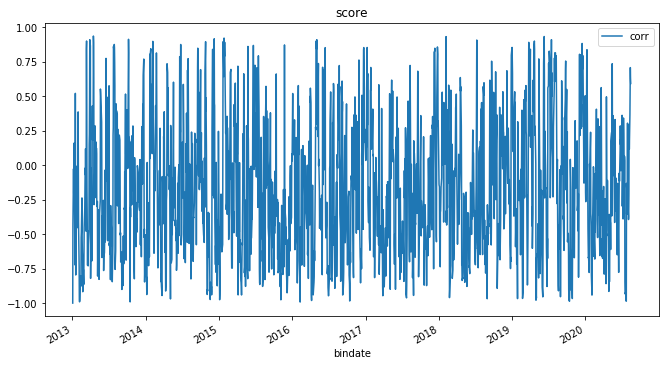

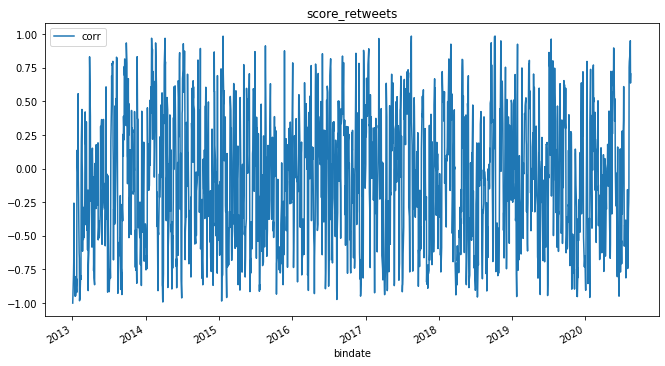

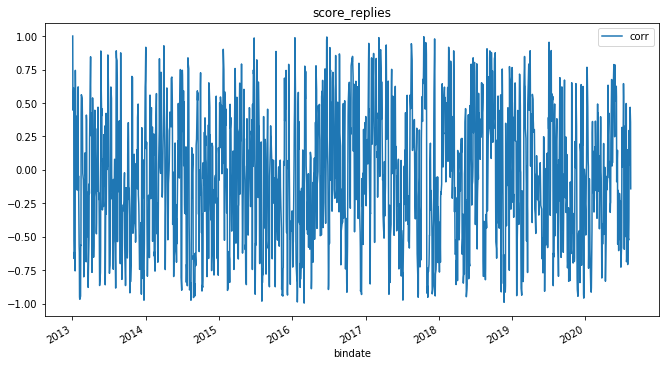

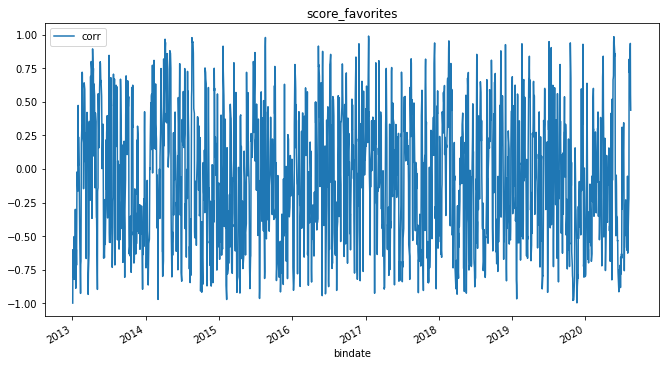

In [37]:
def plot_corr(s):
    s.reset_index().rename(columns={0:'corr'}).plot(kind='line', x='bindate', y='corr', figsize=(11,6))
for var in ['score', 'score_retweets', 'score_replies', 'score_favorites']:
    print(var)
    print(ftse13[var].corr(ftse13['Returns']))
    print(ftse13[var].shift(1).corr(ftse13['Returns']))
    s = ftse13[var].shift(1).rolling(window=5,min_periods=1).corr(ftse13['Returns'])
    plot_corr(s)
    plt.title(var)


- Shifted Correlation Scores are Volatile and Low

## ^ Rolling Mean(Weekly) for each variable and the correlation to Returns

# Backtesting and Devising a Trading Strategy

## Evaluate the Accumulated returns |  P&L Vector

## Make a Decision on which position to take based on Twitter sentiment at the closing time.

- Having a “long” position in a security means that you own the security. Investors maintain “long” security positions in the expectation that the stock will rise in value in the future. The opposite of a “long” position is a “short” position.

- A "short" position is generally the sale of a stock you do not own. Investors who sell short believe the price of the stock will decrease in value. If the price drops, you can buy the stock at the lower price and make a profit.

score
score_retweets
score_replies
score_favorites


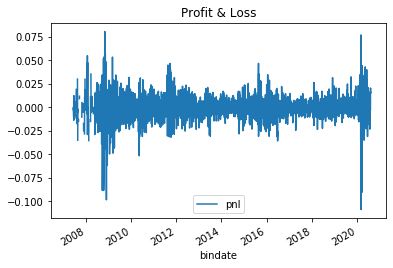

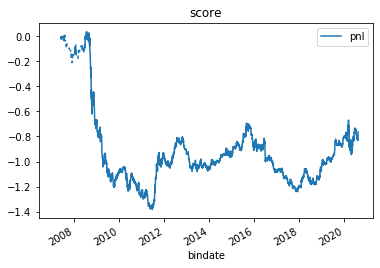

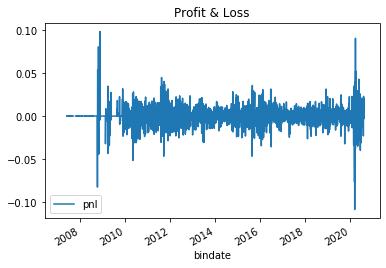

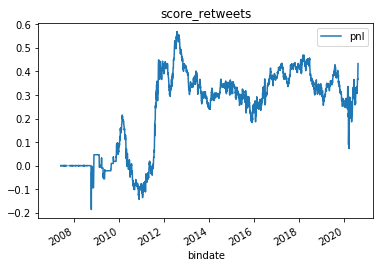

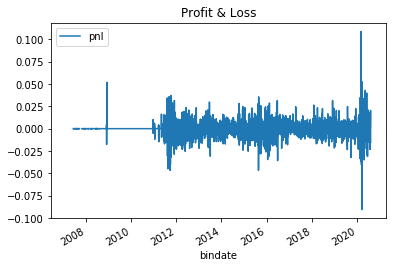

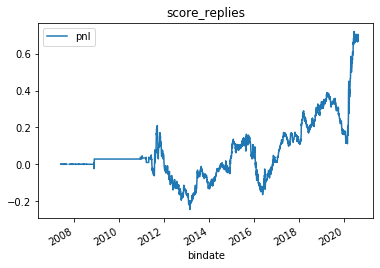

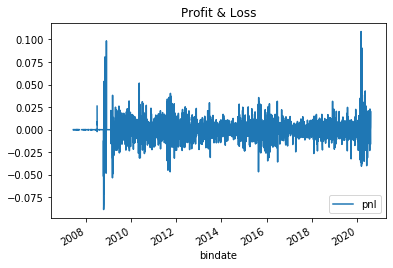

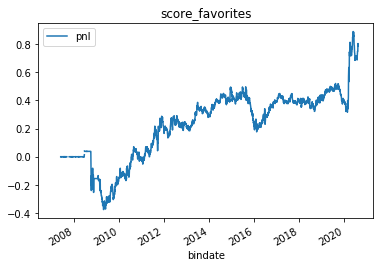

In [44]:
def plot_pnl(s):
    s = s.to_frame(name='pnl')
    s = s.reset_index()
    s.plot(kind='line', x='bindate', y='pnl')
for var in ['score', 'score_retweets', 'score_replies', 'score_favorites']:
    pos = ftse[var]
    print(var)
    pos = pos - pos.rolling(window=5,min_periods=1).mean()  #subtract bias 
    # position vector decide whether ot long or short it
    pos = np.sign(pos)#convert to 1 or -1
    pnl = pos.shift(1) * ftse.Returns
    plot_pnl(pnl)
    plt.title('Profit & Loss')
    cumpnl = pnl.cumsum()
    plot_pnl(cumpnl)
    plt.title(var)
    #plot_pnl(ftse.Returns.cumsum())
   # plt.title('FTSE')

# Score_Replies and Score_Retweets are highly correlated/ and or Predictive

- Correlation and Causation, could tweets influence trading patterns?

Possibly, tweets that cause a lot more replies are likely to be opinions/speculations on future stock behavior. Consequently, the Users that post them may have alot of followers.
Also because there is a discussion involved, the replies from the tweet could influence users trading behaviour who read or replied to that tweet.

- It is highly probable that these opinions seep through and influence other people decisions. So may be Causality involved? 

- The tweets are Predictive and portrays present market sentiment

In [45]:
ftse13= ftse[ftse.index>=datetime(2013,1,1)] #Start at 2013(more tweets per day)
ftse13

,score,score_retweets,score_replies,score_favorites,retweets,favorites,replies,Close,Returns
bindate,,,,,,,,,
2013-01-01,0.050727,-0.208900,0.320875,0.000000,18.0,0.0,4.0,5897.81,0.000000
2013-01-02,0.070267,0.174218,0.293008,0.095222,99.0,9.0,26.0,6027.37,0.021967
2013-01-03,0.211909,0.238970,0.120747,0.303846,94.0,13.0,34.0,6047.34,0.003313
2013-01-04,0.050287,0.122616,0.178419,0.478550,57.0,4.0,26.0,6089.84,0.007028
2013-01-07,0.178135,0.054998,0.154537,0.137562,130.0,26.0,19.0,6064.58,-0.004148
...,...,...,...,...,...,...,...,...,...
2020-08-10,0.146385,0.255829,0.276632,0.279631,242.0,693.0,97.0,6050.59,0.003052
2020-08-11,0.179729,0.426062,0.210567,0.382079,128.0,490.0,91.0,6154.34,0.017147
2020-08-12,0.116080,0.210003,0.188777,0.246521,298.0,936.0,129.0,6280.12,0.020438


- Get the annualized profit and calculate the Compound annual growth rate (CAGR)

Score Replies from 2013 has CAGR:
    - 5.96 %
If starting from 2014: 9.6%

So overall Twitter is predictive, better than the interest rate from the Bank of England!!


# The Trading Strategy:
## - Choose a position either Long or Short depending on if the twitter sentiment score on a specific date is greater or lower than the last weeks/5 business days (time period) average.

In [46]:
# ftse = pd.DataFrame(np.random.randn(1000, 4),
#              index=ts.index, columns=list('ABCD'))

In [47]:
from matplotlib import pyplot as plt

## Trading Strategy Process
- Set a Position Vector ( Get a mean zero. This subtracts the Bias)
- Convert it to 1 or -1 (Long or Short)
- Profit & Loss, Look at the position taken yesterday and todays Return (I.e. If we chose Long yesterday and Return today is positive than ther is a Profit)
- Cumulative Profit & Loss ( Accumulates the Profits since the start date)
- Finally Plot the Graphs and Get Nice Visuals!

score
score_retweets
score_replies
score_favorites


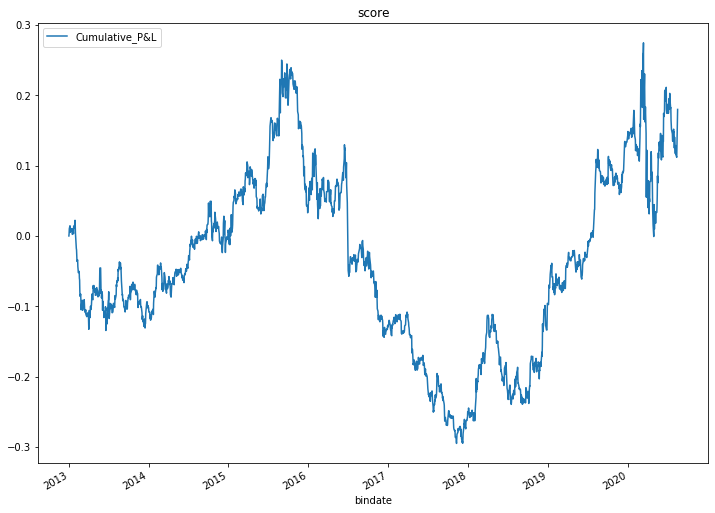

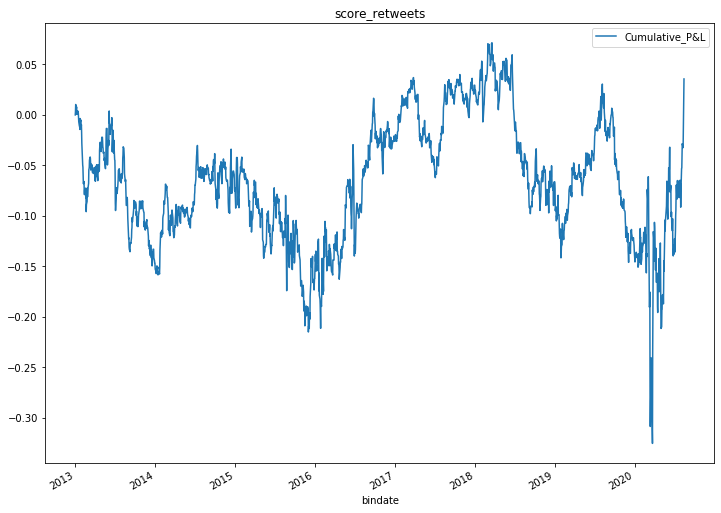

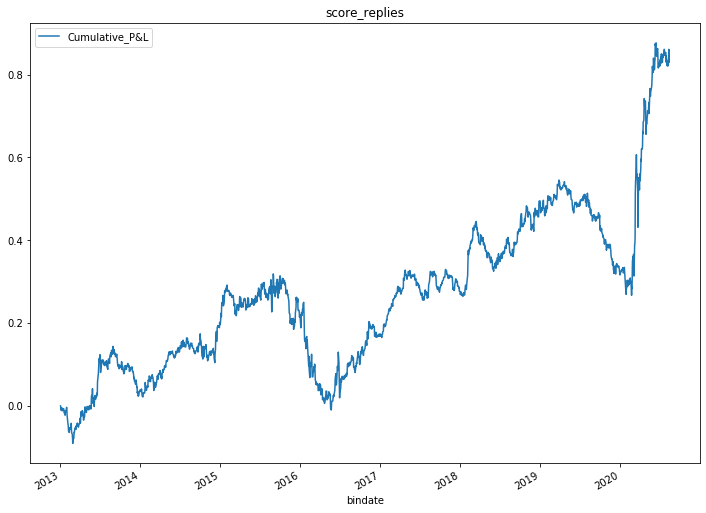

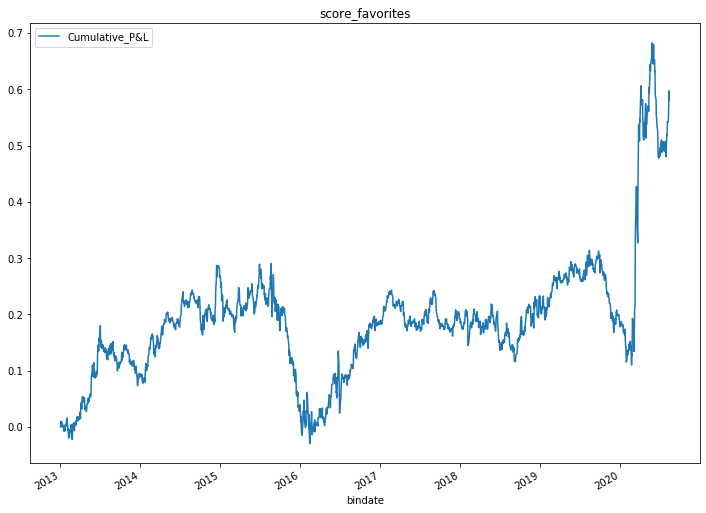

In [48]:
def plot_pnl(s):
    s = s.to_frame(name='Cumulative_P&L')
    s = s.reset_index()
    s.plot(kind='line', x='bindate', y='Cumulative_P&L', figsize=(12,9) )
for var in ['score', 'score_retweets', 'score_replies', 'score_favorites']:
    pos = ftse13[var]
    print(var)
    pos = pos - pos.rolling(window=5,min_periods=1).mean()  #subtracts bias
    # position vector long or short it
    pos = np.sign(pos)#convert to 1 or -1
    pnl = pos.shift(1) * ftse.Returns
    cumpnl = pnl.cumsum()
    plot_pnl(cumpnl)
    plt.title(var)

Text(0.5, 1.0, 'FTSE')

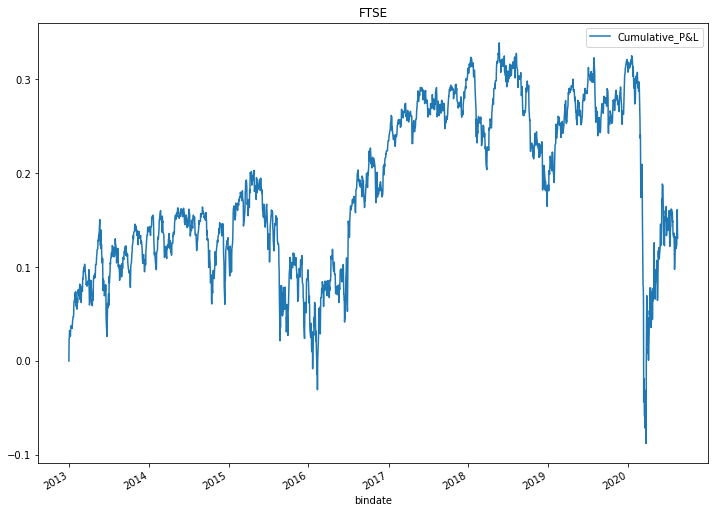

In [49]:
plot_pnl(ftse13.Returns.cumsum())
plt.title('FTSE')

Text(0.5, 1.0, 'Profit & Loss')

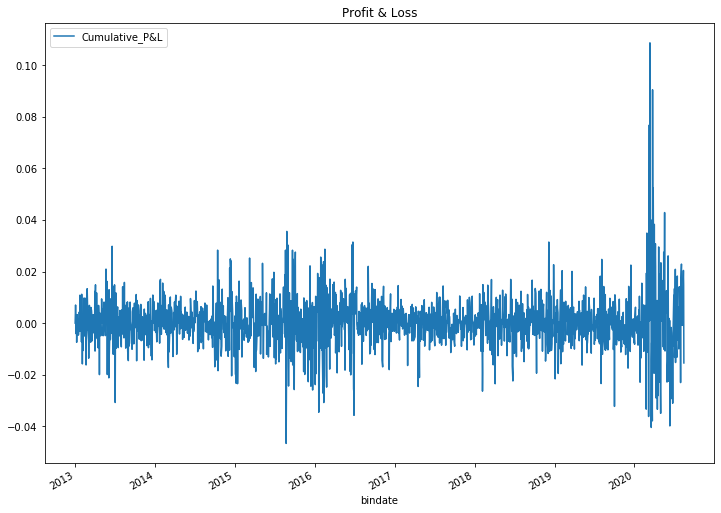

In [50]:
plot_pnl(pnl)
plt.title('Profit & Loss')

## Adding a new column called 'optimal_score' 
- Optimally weighted and lookback scores which maximise the Sharpe Ratio
- The computing to get the 'optimal_score' column are done in the next section below

In [51]:
ftse13['optimal_score'] = 0.3*ftse13.score + 0.2*ftse13.score_retweets + 0.4*ftse13.score_replies + 0.1*ftse13.score_favorites

/Users/ataiotorbaev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
ftse13

,score,score_retweets,score_replies,score_favorites,retweets,favorites,replies,Close,Returns,optimal_score
bindate,,,,,,,,,,
2013-01-01,0.050727,-0.208900,0.320875,0.000000,18.0,0.0,4.0,5897.81,0.000000,0.101788
2013-01-02,0.070267,0.174218,0.293008,0.095222,99.0,9.0,26.0,6027.37,0.021967,0.182649
2013-01-03,0.211909,0.238970,0.120747,0.303846,94.0,13.0,34.0,6047.34,0.003313,0.190050
2013-01-04,0.050287,0.122616,0.178419,0.478550,57.0,4.0,26.0,6089.84,0.007028,0.158832
2013-01-07,0.178135,0.054998,0.154537,0.137562,130.0,26.0,19.0,6064.58,-0.004148,0.140011
...,...,...,...,...,...,...,...,...,...,...
2020-08-10,0.146385,0.255829,0.276632,0.279631,242.0,693.0,97.0,6050.59,0.003052,0.233697
2020-08-11,0.179729,0.426062,0.210567,0.382079,128.0,490.0,91.0,6154.34,0.017147,0.261566
2020-08-12,0.116080,0.210003,0.188777,0.246521,298.0,936.0,129.0,6280.12,0.020438,0.176987


score
0.1450019271904248
score_retweets
0.028753019956425315
score_replies
0.670240885675957
score_favorites
0.46919295607869493
optimal_score
0.6836777690933067


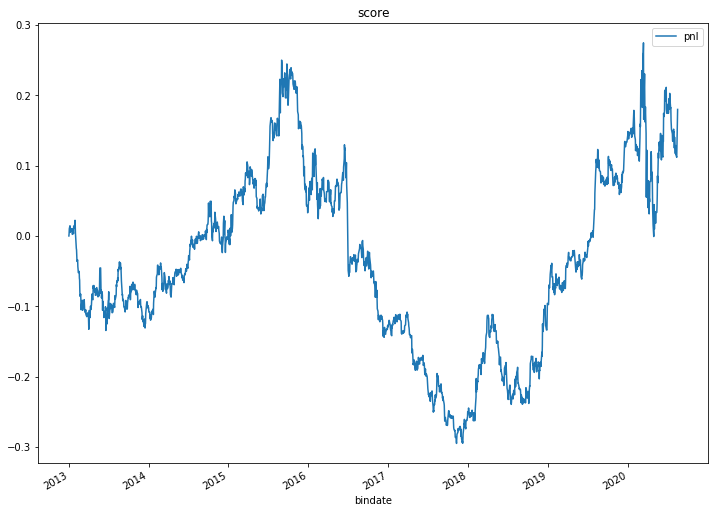

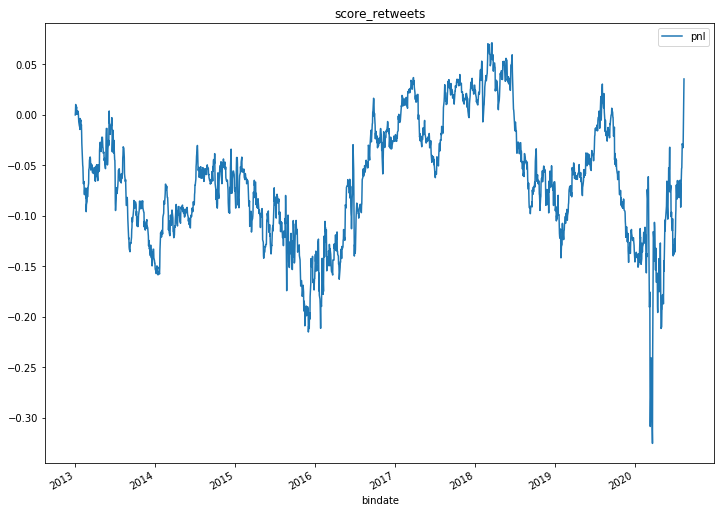

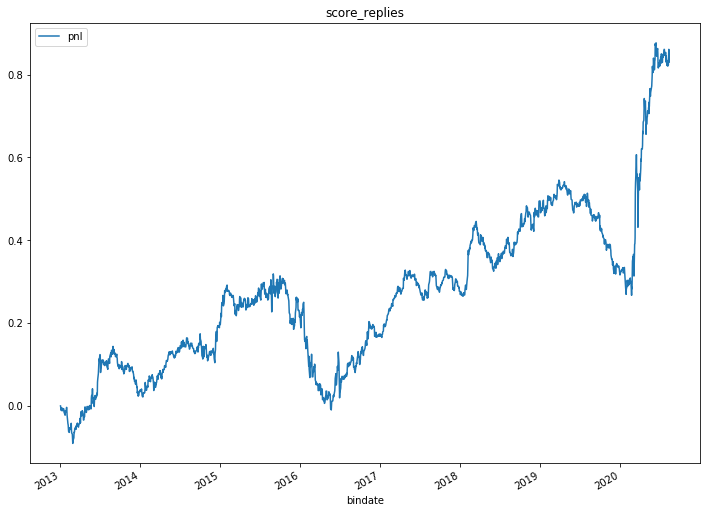

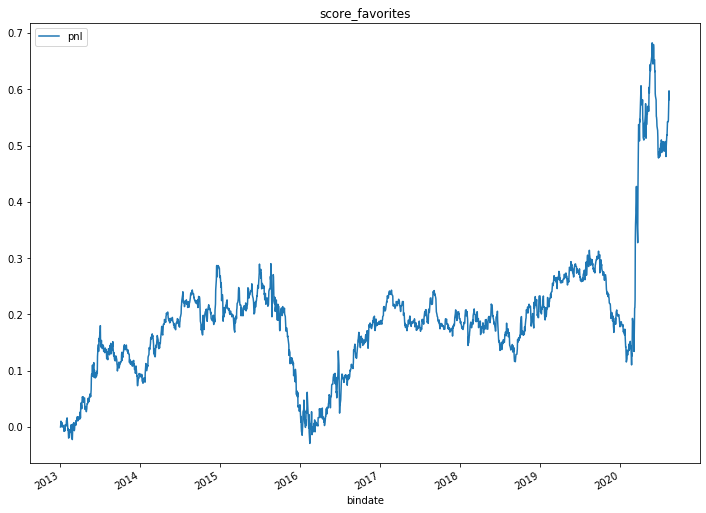

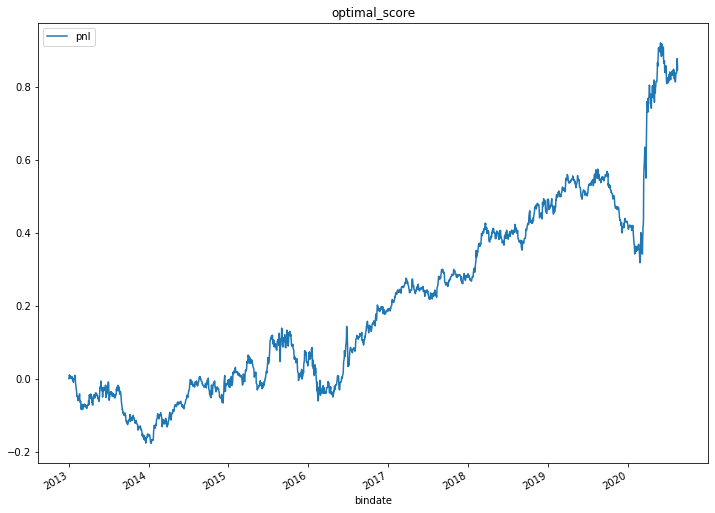

In [53]:
def plot_pnl(s):
    s = s.to_frame(name='pnl')
    s = s.reset_index()
    s.plot(kind='line', x='bindate', y='pnl', figsize=(12,9))
    
for var in ['score', 'score_retweets', 'score_replies', 'score_favorites', 'optimal_score']: #
    pos = ftse13[var]
    print(var)
    pos = pos - pos.rolling(window=5,min_periods=1).mean()  #subtract bias, takes the average over a 1 week period
    # position vector long or short it
    # todays sentiment subtracted from last week
    pos = np.sign(pos)#convert to 1 or -1
    pnl = pos.shift(1) * ftse.Returns
#     plot_pnl(pnl)
    cumpnl = pnl.cumsum()
    sharpe = np.sqrt(252) * pnl.mean()/pnl.std()#pnl standard profit and loss
    print(sharpe)
    plot_pnl(cumpnl)
    plt.title(var)
    #plot_pnl(ftse13.Returns.cumsum())

Standard Profit & Loss

Strategy stay long or short depending if a date's specific sentiment is greater or lower than the last 3 month(timeperiod)
average

In [54]:
#^reweight and create a new column from the different scores to achieve a higher correlation ?
#the score favorites to get a higher correlation
# count the most common words used from the dictionary!
# predict the hours ahead??§

In [55]:
#Regression (dates) and tweet features , framework shift to match up, regress 
# target returns

# Grisearch to get the optimal Sharpe Ratio.
## The EDA is done in the previous section above 


In [56]:
import itertools
list(itertools.permutations([0.1, 0.2, 0.3, 0.4]))

[(0.1, 0.2, 0.3, 0.4),
 (0.1, 0.2, 0.4, 0.3),
 (0.1, 0.3, 0.2, 0.4),
 (0.1, 0.3, 0.4, 0.2),
 (0.1, 0.4, 0.2, 0.3),
 (0.1, 0.4, 0.3, 0.2),
 (0.2, 0.1, 0.3, 0.4),
 (0.2, 0.1, 0.4, 0.3),
 (0.2, 0.3, 0.1, 0.4),
 (0.2, 0.3, 0.4, 0.1),
 (0.2, 0.4, 0.1, 0.3),
 (0.2, 0.4, 0.3, 0.1),
 (0.3, 0.1, 0.2, 0.4),
 (0.3, 0.1, 0.4, 0.2),
 (0.3, 0.2, 0.1, 0.4),
 (0.3, 0.2, 0.4, 0.1),
 (0.3, 0.4, 0.1, 0.2),
 (0.3, 0.4, 0.2, 0.1),
 (0.4, 0.1, 0.2, 0.3),
 (0.4, 0.1, 0.3, 0.2),
 (0.4, 0.2, 0.1, 0.3),
 (0.4, 0.2, 0.3, 0.1),
 (0.4, 0.3, 0.1, 0.2),
 (0.4, 0.3, 0.2, 0.1)]

In [57]:
wts = list(itertools.permutations([0.1, 0.2, 0.3, 0.4]))
wts = wts+[(1,0,0,0), (0,1,0,0), (0,0,1,0), (0,0,0,1)]
lookbacks = [5] + list(range(22,22*13,22))

def calc_sharpe(lookback, wt):
    pos = wt[0]*ftse13.score + wt[1]*ftse13.score_retweets + wt[2]*ftse13.score_replies + wt[3]*ftse13.score_favorites
    pos = pos - pos.rolling(window=lookback, min_periods=1).mean()  #subtract bias, takes the average over a different period
    # position vector long or short it
    # todays sentiment subtracted the last 3month
    pos = np.sign(pos)#convert to 1 or -1
    pnl = pos.shift(1) * ftse.Returns
    sharpe = np.sqrt(252) * pnl.mean()/pnl.std()#pnl standard profit and loss
    return sharpe

maxsharpe = 0 
maxvars = None
for wt in wts:
    for lookback in lookbacks:
        sharpe = calc_sharpe(lookback, wt)
        if sharpe > maxsharpe:
            maxsharpe =sharpe
            maxvars = (wt, lookback)
            
print(maxsharpe)
print(maxvars)

0.6836777690933067
((0.3, 0.2, 0.4, 0.1), 5)


In [58]:
for var in ['score', 'score_retweets', 'score_replies', 'score_favorites', 'optimal_score']:
    pos = ftse13[var]
    print(var)
    pos = pos - pos.rolling(window=5,min_periods=1).mean()  #subtract bias
    pos = np.sign(pos)#convert to 1 or -1
    pnl = pos.shift(1) * ftse.Returns
    sharpe = np.sqrt(252) * pnl.mean()/pnl.std()#pnl standard profit and loss
    print(sharpe)

score
0.1450019271904248
score_retweets
0.028753019956425315
score_replies
0.670240885675957
score_favorites
0.46919295607869493
optimal_score
0.6836777690933067


The ratio describes how much excess return you receive for the extra volatility you endure for holding a riskier asset


S(x)= 
StdDev(r x)(r x	 −R f )
	 
where:
x=The investment
r 
x
	 =The average rate of return of x
R 
f
	 =The best available rate of return of a 
risk-free security (i.e. T-bills)
StdDev(x)=The standard deviation of r 
x
	 
	

In [59]:
#R2 IS LOW
#RMSE HIGH calculate

# Baseline

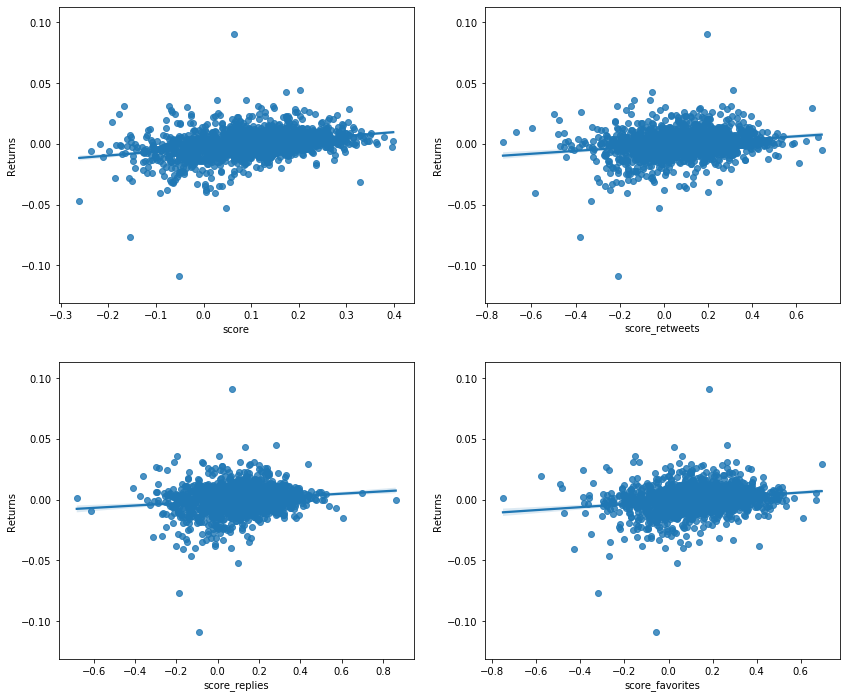

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(14,12))
ax=ax.ravel()
for ind,val in enumerate(['score', 'score_retweets', 'score_replies', 'score_favorites']):
    sns.regplot(ftse13[val], ftse13['Returns'], ax=ax[ind])

In [61]:
ftse13.Returns.value_counts(normalize=True).max()

0.028240040342914774

# The shifted regression will not be a good fit. But its good nevertheless, because i conducted a backtest which shows that economically it is good option

Strategy: Choose a position(long or short) depending on a date's mean sentiment score is greater or lower than the last weeks (timeperiod) average

Overall: pretty good the return or CAGR is higher than the Index

# Shifted Linear Regression

In [62]:
pnl13 = pnl[pnl.index>=datetime(2013,1,1)]
pnl13

bindate
2013-01-01         NaN
2013-01-02    0.000000
2013-01-03    0.003313
2013-01-04    0.007028
2013-01-07   -0.004148
                ...   
2020-08-10    0.003052
2020-08-11    0.017147
2020-08-12    0.020438
2020-08-13   -0.015047
2020-08-14   -0.015452
Length: 1983, dtype: float64

In [63]:
cumpnl13 = cumpnl[cumpnl.index>=datetime(2013,1,1)]
cumpnl13

bindate
2013-01-01         NaN
2013-01-02    0.000000
2013-01-03    0.003313
2013-01-04    0.010341
2013-01-07    0.006193
                ...   
2020-08-10    0.840264
2020-08-11    0.857411
2020-08-12    0.877848
2020-08-13    0.862801
2020-08-14    0.847349
Length: 1983, dtype: float64

In [64]:
# pos = ftse13[var]

pos = pos - pos.rolling(window=22*2,min_periods=1).mean() 
pos

bindate
2013-01-01    0.000000
2013-01-02    0.500000
2013-01-03    0.333333
2013-01-04    0.250000
2013-01-07   -1.400000
                ...   
2020-08-10    1.045455
2020-08-11    1.045455
2020-08-12    1.000000
2020-08-13    0.954545
2020-08-14    0.909091
Name: optimal_score, Length: 1983, dtype: float64

In [65]:
feature_cols = ['score', 'score_retweets', 'score_replies', 'score_favorites']
#feature_cols = ['optimal_score']


In [66]:
Xi = ftse13[feature_cols].shift(1)
y =  ftse13.Returns
# y =pos

In [67]:
Xi= Xi.fillna(0)
Xi.head()

,score,score_retweets,score_replies,score_favorites
bindate,,,,
2013-01-01,0.000000,0.000000,0.000000,0.000000
2013-01-02,0.050727,-0.208900,0.320875,0.000000
2013-01-03,0.070267,0.174218,0.293008,0.095222
2013-01-04,0.211909,0.238970,0.120747,0.303846
2013-01-07,0.050287,0.122616,0.178419,0.478550


In [68]:
y = y.fillna(0)
y

bindate
2013-01-01    0.000000
2013-01-02    0.021967
2013-01-03    0.003313
2013-01-04    0.007028
2013-01-07   -0.004148
                ...   
2020-08-10    0.003052
2020-08-11    0.017147
2020-08-12    0.020438
2020-08-13   -0.015047
2020-08-14   -0.015452
Name: Returns, Length: 1983, dtype: float64

In [69]:
#Baseline
y.value_counts(normalize=True).max()

0.028240040342914774

In [70]:
X_train, X_test, y_train, y_test = train_test_split(Xi, y,  test_size=0.2, shuffle=False, random_state=1)

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=Xi.columns) 
X_test = pd.DataFrame(scaler.transform(X_test), columns=Xi.columns)

In [80]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
metrics.mean_squared_error(y_test, model.predict(X_test)),


(0.00021361841664748884,)

In [81]:
model.intercept_, model.coef_

(0.0001279535836349913,
 array([-0.00025023, -0.00047331,  0.00010033,  0.00049376]))

In [82]:
predictions = model.predict(Xi)

In [83]:
model.score(Xi, y)

0.00046729616815155417

In [86]:
from sklearn.metrics import r2_score

r2_score(y, predictions)

0.00046729616815155417

In [87]:
linreg = LinearRegression(fit_intercept=False)
linreg.fit(Xi, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [88]:
linreg.score(Xi, y)

0.0022320055663610505

In [90]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, predictions)

9.881665134607674e-05

In [91]:
#sorted(sklearn.metrics.SCORERS.keys())

In [92]:
scoring = mean_squared_error(y_test, model.predict(X_test))

In [93]:
model = LinearRegression()

scores = cross_val_score(model, X_train, y_train, cv=5) 

print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean()) 
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [-0.0052319  -0.00363296 -0.00359711 -0.00285384 -0.01098714]
Mean cross-validated training score: -0.0052605916793220684
Training Score: 0.002574537329825488
Test Score: 0.0009071482693060462


In [94]:
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

,coefficients,coef_abs
score,-0.000250,0.000250
score_retweets,-0.000473,0.000473
score_replies,0.000100,0.000100
score_favorites,0.000494,0.000494


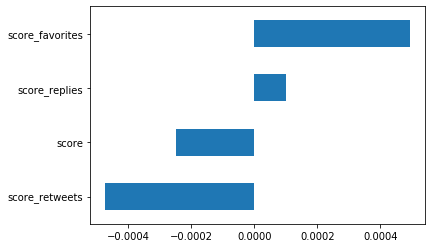

In [95]:
df_coef['coefficients'].sort_values().plot(kind='barh')

In [101]:
from sklearn.linear_model import RidgeCV

model = RidgeCV(alphas=np.logspace(-16, 4, 10), cv=5)# =log cause its squared
# fit the model
model.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', model.alpha_)
# evaluate on the training set
print('Training score:', model.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", model.score(X_test, y_test))

Best alpha: 10000.0
Training score: 0.0003476178400056984
Test Score: -0.00044565395231099814
